In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from shapely.geometry import Polygon

import geopandas as gpd


In [2]:
def bezier_curve(start, control1, control2, end, n=100):
    """Generate a cubic Bezier curve."""
    t = np.linspace(0, 1, n)[:, None]  # shape (n, 1)
    start, control1, control2, end = map(np.array, [start, control1, control2, end])
    curve = (
        (1 - t)**3 * start
        + 3 * (1 - t)**2 * t * control1
        + 3 * (1 - t) * t**2 * control2
        + t**3 * end
    )
    return curve


def flow_patch(start, end, start_width, end_width, ctrl_offset=(1, 0), color="C0", y0=0):
    """Draw a tapered flow between two points with smooth edges, offset vertically by y0."""
    # Apply y-offset
    start = (start[0], start[1] + y0)
    end = (end[0], end[1] + y0)
    ctrl1 = (start[0] + ctrl_offset[0], start[1] + ctrl_offset[1])
    ctrl2 = (end[0] - ctrl_offset[0], end[1] - ctrl_offset[1])

    # Top and bottom Bezier curves (offset by half the widths)
    top = bezier_curve(
        (start[0], start[1] + start_width / 2),
        (ctrl1[0], ctrl1[1] + start_width / 2),
        (ctrl2[0], ctrl2[1] + end_width / 2),
        (end[0], end[1] + end_width / 2)
    )
    bottom = bezier_curve(
        (end[0], end[1] - end_width / 2),
        (ctrl2[0], ctrl2[1] - end_width / 2),
        (ctrl1[0], ctrl1[1] - start_width / 2),
        (start[0], start[1] - start_width / 2)
    )

    # Build a closed path
    verts = np.concatenate([top, bottom])
    verts = np.vstack([verts, verts[0]])  # close the shape
    codes = (
        [Path.MOVETO]
        + [Path.LINETO] * (len(top) - 1)
        + [Path.LINETO] * len(bottom)
        + [Path.CLOSEPOLY]
    )

    path = Path(verts, codes)
    patch = PathPatch(path, facecolor=color, edgecolor="none", alpha=0.7)
    return patch

In [3]:
#ok I am going to make a short array describing the ons/offs and such

## first column is stop num, second column is on, third column is off.
rider_numbers = {
    1: [5, 0], #5
    2: [3, 2], #6
    3: [2, 4]  #4
}

In [4]:
def makePatch(column, start_mid_height, end_mid_height, Line_Width, Color):
    #p1 = flow_patch(start=(0, 0), end=(3, 0), start_width=10, end_width=10, color="C0", y0=1)
    section_size_const = 5
    return (flow_patch(start=(column * section_size_const, start_mid_height), end=((column+1) * section_size_const, end_mid_height), start_width=Line_Width, end_width=Line_Width, color=Color, y0=0))
    

In [5]:
def makeTheCurve(column, start_mid_height, end_mid_height, Line_Width, Color):
    ## column (left to right column), middle point of starting height, middle point of ending height, width at start, width at end
    #color options = C0, C1, C2
    section_size_const = 5
    
    ax.add_patch(flow_patch(start=(column * section_size_const, start_mid_height), end=((column+1) * section_size_const, end_mid_height), start_width=Line_Width, end_width=Line_Width, color=Color, y0=0)) ## first main

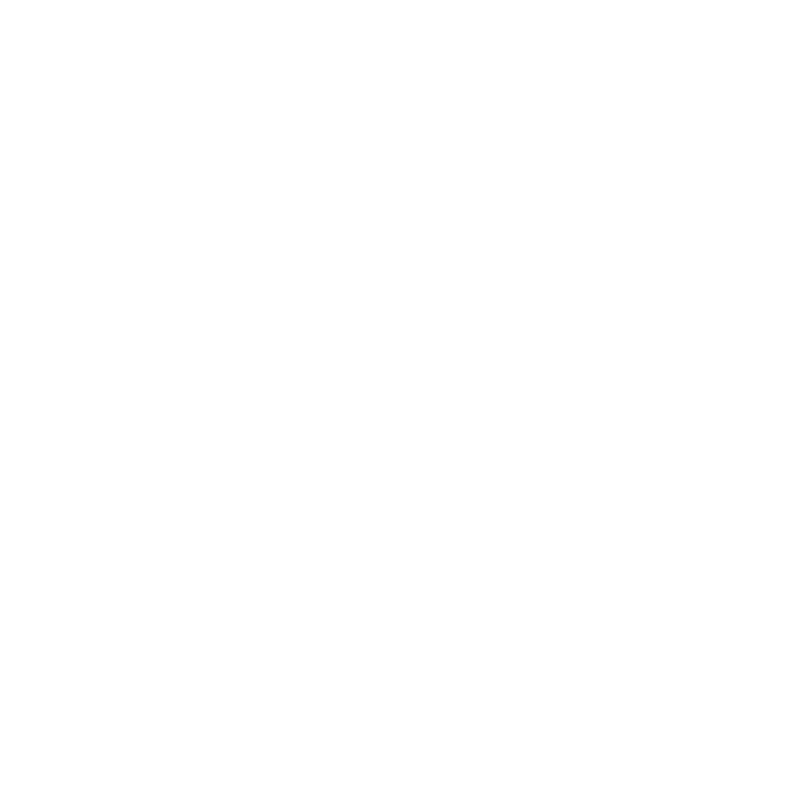

In [6]:
#In this cell I am going to attempt to make a sankey that is true to the on/off numbers I fabricated.
fig, ax = plt.subplots(figsize=(10, 10))

#method signiature of makeTheCurve(column, start_mid_height, end_mid_height, Line_Width, Color)
patch1 = makePatch(0, 9, 10, 5, 'C0') # main line ## from

#first stop actions
patch2 = makePatch(0, 15, 14, 3, 'C1') # boarding line
## total vertical strech after initial (initial main + first boarding ) is 7.5 to 15.5

patch3 = makePatch(1, 12.5, 11.5, 6, 'C0') # main line
patch4 = makePatch(1, 8.5, 7, 2, 'C2') # alighting line

## second stop
patch5 = makePatch(1, 17.5, 15.5, 2,'C1')# boarding line

patch6 = makePatch(2, 14.5, 12.5, 4, 'C0')# main line
patch7 = makePatch(2, 10.5, 7, 4, 'C2') #alighting line

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_aspect("equal")
ax.axis("off")

plt.show()


In [7]:
### going to try to put it all on an interactive map. 

def patch_to_polygon(patch):
    """Convert a Matplotlib PathPatch into a Shapely Polygon."""
    path = patch.get_path()
    verts = patch.get_transform().transform(path.vertices)
    return Polygon(verts)

In [8]:


patches = []

patches = [patch1, patch2, patch3, patch4, patch5, patch6, patch7]

# Convert patches → Shapely polygons
geoms = [patch_to_polygon(p) for p in patches]

# Build GeoDataFrame
gdf = gpd.GeoDataFrame({"geometry": geoms})
gdf.set_crs("EPSG:4326", inplace=True)   # Fake coordinates for now

,geometry
0,"POLYGON ((0 11.5, 0.03091 11.5003, 0.06302 11...."
1,"POLYGON ((0 16.5, 0.03091 16.4997, 0.06302 16...."
2,"POLYGON ((5 15.5, 5.03091 15.4997, 5.06302 15...."
3,"POLYGON ((5 9.5, 5.03091 9.49954, 5.06302 9.49..."
4,"POLYGON ((5 18.5, 5.03091 18.49939, 5.06302 18..."
5,"POLYGON ((10 16.5, 10.03091 16.49939, 10.06302..."
6,"POLYGON ((10 12.5, 10.03091 12.49894, 10.06302..."


In [9]:
import folium

m = folium.Map(location=[0, 0], zoom_start=4)

for poly in geoms:
    folium.GeoJson(poly).add_to(m)

m

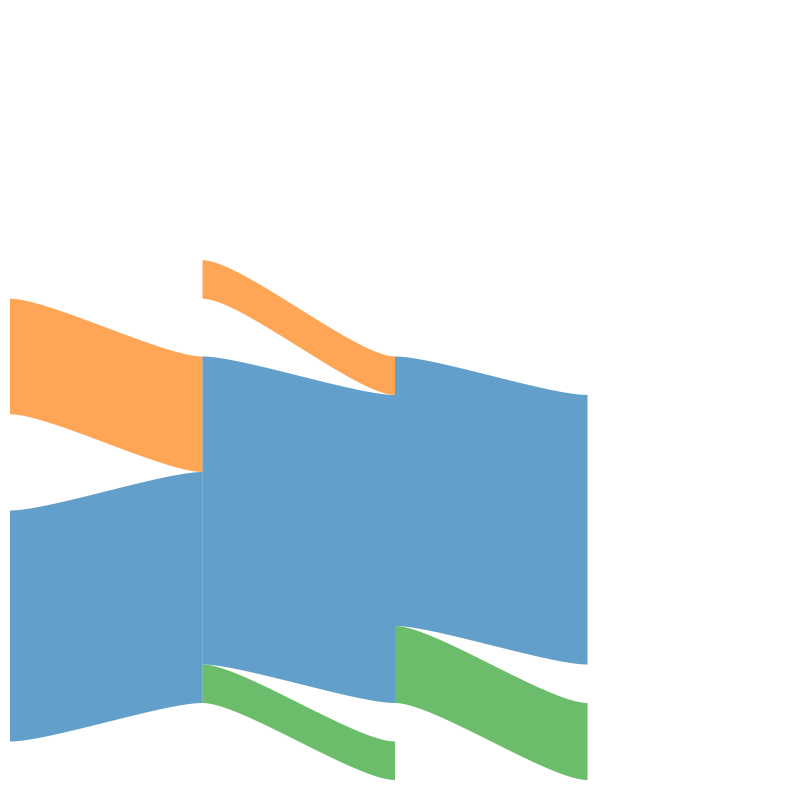

In [10]:

### Ok this one is somewhat of a proof of concept.

fig, ax = plt.subplots(figsize=(10, 10))
### color list --> "C0":light blue,  "C1":, "C2":

#(column, start_mid_height, end_mid_height, Line_Width, Color)

#first column
makeTheCurve(0, 4, 5, 6, 'C0') # main line

#second column
makeTheCurve(0, 11, 9.5, 3, 'C1')#boarding line
makeTheCurve(1, 7, 6, 8, 'C0')#main line 
makeTheCurve(1, 2.5, 0.5, 1, 'C2')#alighting line


##third colum, incoming main line streches from 2 to 10.

makeTheCurve(1, 13, 10.5, 1, 'C1') #boarding line
makeTheCurve(2, 7.5, 6.5, 7, 'C0')# main line starting bottom = 4, starting top = 11
makeTheCurve(2, 3, 1, 2, 'C2')#alighting line

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_aspect("equal")
ax.axis("off")

plt.show()

In [11]:
"""

fig, ax = plt.subplots(figsize=(10, 10))

# Main flow (width 10)

ax.add_patch(flow_patch(start=(0, 0), end=(5, 0), start_width=10, end_width=9, color="C0", y0=10)) ## first main
ax.add_patch(flow_patch(start=(5, 0), end=(10, 0), start_width=9, end_width=10, color="C0", y0=10)) ## second main



# Split into two flows (6 and 4), below the main one
ax.add_patch(flow_patch(start=(0, 2), end=(5, 0), start_width=3, end_width=4, color="C1", y0=16.5)) ## first boarding


ax.add_patch(flow_patch(start=(5, 0), end=(10, -1), start_width=3, end_width=4, color="C2", y0=5)) ## first exit

# Add another example flow offset downward
#ax.add_patch(flow_patch(start=(0, 0), end=(3, 0), start_width=8, end_width=8, color="C3", y0=-3))
#ax.add_patch(flow_patch(start=(3, 0), end=(6, 1), start_width=5, end_width=5, color="C4", y0=-3))
#ax.add_patch(flow_patch(start=(3, 0), end=(6, -1), start_width=3, end_width=3, color="C5", y0=-3))

ax.set_xlim(0, 17)
ax.set_ylim(0, 20)
ax.set_aspect("equal")
ax.axis("off")

plt.show()

"""

'\n\nfig, ax = plt.subplots(figsize=(10, 10))\n\n# Main flow (width 10)\n\nax.add_patch(flow_patch(start=(0, 0), end=(5, 0), start_width=10, end_width=9, color="C0", y0=10)) ## first main\nax.add_patch(flow_patch(start=(5, 0), end=(10, 0), start_width=9, end_width=10, color="C0", y0=10)) ## second main\n\n\n\n# Split into two flows (6 and 4), below the main one\nax.add_patch(flow_patch(start=(0, 2), end=(5, 0), start_width=3, end_width=4, color="C1", y0=16.5)) ## first boarding\n\n\nax.add_patch(flow_patch(start=(5, 0), end=(10, -1), start_width=3, end_width=4, color="C2", y0=5)) ## first exit\n\n# Add another example flow offset downward\n#ax.add_patch(flow_patch(start=(0, 0), end=(3, 0), start_width=8, end_width=8, color="C3", y0=-3))\n#ax.add_patch(flow_patch(start=(3, 0), end=(6, 1), start_width=5, end_width=5, color="C4", y0=-3))\n#ax.add_patch(flow_patch(start=(3, 0), end=(6, -1), start_width=3, end_width=3, color="C5", y0=-3))\n\nax.set_xlim(0, 17)\nax.set_ylim(0, 20)\nax.set_as